# Rumor Detection Demo

In [1]:
import numpy as np
import tensorflow as tf
import helpers ## formatting data, and generate random sequence data

%matplotlib inline
import matplotlib.pyplot as plt

tf.reset_default_graph()
sess = tf.InteractiveSession()

In [2]:
tf.__version__

'1.2.0-rc0'

In [3]:
batch_size = 100 # minibatch size
vocab_size = 10  # vocab size 10 for digits [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
input_embedding_size = 20 # dimension of embedding vector for each digit

In [4]:
inputs = tf.placeholder(shape=(batch_size, None), dtype=tf.int32, name='inputs')
inputs_length = tf.placeholder(shape=(batch_size,), dtype=tf.int32, name='inputs_length')
target_inputs = tf.placeholder(shape=(batch_size, None), dtype=tf.int32, name='target_inputs')

## Embeddings

In [5]:
embeddings = tf.Variable(tf.random_uniform([vocab_size, input_embedding_size], -1.0, 1.0), dtype=tf.float32)

inputs_embedded = tf.nn.embedding_lookup(embeddings, inputs)

## RNN Architecture

* RNN에서 주로 쓰이는 cell에는 크게 LSTM과 GRU cell이 있다. [link](http://colah.github.io/posts/2015-08-Understanding-LSTMs)

 * LSTM  
  ![alt text](http://colah.github.io/posts/2015-08-Understanding-LSTMs/img/LSTM3-chain.png "LSTM")
  
 * GRU  
  ![GRU](http://colah.github.io/posts/2015-08-Understanding-LSTMs/img/LSTM3-var-GRU.png "GRU")
  
* 여기서는 RNN cell중 GRU를 선택하고 다음과 같은 RNN format 중에서 many-to-one 을 선택하여 만든다. [link](http://karpathy.github.io/2015/05/21/rnn-effectiveness/)
  ![RNN format](http://karpathy.github.io/assets/rnn/diags.jpeg)


In [6]:
import tensorflow.contrib.rnn as rnn

num_hidden_units = 20
num_layers = 3

# residual wrapper는 residual connection을 자동으로 생성해주며
# MultiRNNCell은 위의 many to one 그림에서 초록색에 해당하는 RNN layer를 여려층으로 쌓게 해주며
# 여기서는 num_layer=3 개의 레이어를 쌓았다.
cell = rnn.MultiRNNCell([rnn.ResidualWrapper(rnn.GRUCell(num_hidden_units)) for i in range(num_layers)])

outputs, final_state = tf.nn.dynamic_rnn(cell,
                                         inputs_embedded,
                                         inputs_length,
                                         cell.zero_state(batch_size, dtype=tf.float32))

## Rumor probability

In [7]:
# 여기서 계산되는 logits이 위의 many to one 그림에서 파란색에 해당하는 output 결과
logits = tf.layers.dense(inputs=final_state[num_layers-1], 
                         units=2,
                         kernel_initializer=tf.contrib.slim.xavier_initializer())

prediction = tf.argmax(logits, 1)

In [8]:
# 파란색 레이어의 output unit은 2개며 이 2개 유닛을 가지고 softmax를 취한다음 cross entropy를 계산
stepwise_cross_entropy = tf.nn.softmax_cross_entropy_with_logits(
    labels=tf.one_hot(target_inputs, depth=2, dtype=tf.float32),
    logits=logits
)

#loss function (averaged cross entropy for batch set)
loss = tf.reduce_mean(stepwise_cross_entropy)

#train op을 sess에서 호출하면 자동으로 RNN layer들의 variable들이 Gradient descent로 optimize
train_op = tf.train.AdamOptimizer().minimize(loss)

 * 단순하게 input sequence의 가장 첫번째 값이 5보다 작으면 False (0), 5 이상이면 True (1) 라고 하자.
 * next_feed function은 input sequence를 3~8사이의 길이로 무작위 0~9 값을 채워 넣는다.

In [9]:
batch_size = 100

batches = helpers.random_sequences(length_from=3, length_to=8,
                                   vocab_lower=0, vocab_upper=10,
                                   batch_size=batch_size)

print('head of the batch:')
for seq in next(batches)[:10]:
    print(seq)

head of the batch:
[3, 7, 7, 1, 2]
[4, 1, 7, 7, 0, 6]
[7, 6, 2, 6, 9, 7, 4]
[3, 2, 9, 0, 5]
[7, 3, 4, 7, 7, 7]
[6, 7, 0]
[0, 4, 4, 7, 2, 9, 4]
[4, 1, 3, 3]
[3, 1, 2, 2, 3, 8, 9]
[8, 0, 7, 9]


In [10]:
def next_feed():
    batch = next(batches)
    inputs_, input_lengths_ = helpers.batch(batch)
    inputs_ = inputs_.T
    target_inputs_, _ = helpers.batch([np.append(sequence, [1]) for sequence in batch])
#     helpers.batch([np.append(sequence, [1]) for sequence in batch])
#     helpers.batch([np.append(sequence[::-1], [1], axis=0) for sequence in batch])

    target_inputs_ = map(lambda x: [0] if x<5 else [1], target_inputs_.T[:,0:1])

    return {
        inputs: inputs_,
        inputs_length: input_lengths_,
        target_inputs: target_inputs_
    }

In [11]:
max_batches = 3001
batches_in_epoch = 1000
sess.run(tf.global_variables_initializer())

loss_track = []
try:
    for batch in range(max_batches):
        fd = next_feed()
        _, l = sess.run([train_op, loss], fd)
        loss_track.append(l)

        if batch == 0 or batch % batches_in_epoch == 0:
            print('batch {}'.format(batch))
            print('  minibatch loss: {}'.format(sess.run(loss, fd)))
            predict_ = sess.run(prediction, fd)
            for i, (inp, pred) in enumerate(zip(fd[inputs], predict_)):
                print('  sample {}:'.format(i + 1))
                print('    input     > {}'.format(inp))
                print('    predicted > {}'.format(pred))
                if i >= 2:
                    break
            print()

except KeyboardInterrupt:
    print('training interrupted')

batch 0
  minibatch loss: 0.676617741585
  sample 1:
    input     > [7 9 8 3 2 0 0 0]
    predicted > 1
  sample 2:
    input     > [8 2 9 9 7 6 0 4]
    predicted > 1
  sample 3:
    input     > [0 7 9 1 7 9 1 9]
    predicted > 0
()
batch 1000
  minibatch loss: 0.000149777435581
  sample 1:
    input     > [3 3 1 0 0 0 0 0]
    predicted > 0
  sample 2:
    input     > [0 6 7 5 2 0 0 0]
    predicted > 0
  sample 3:
    input     > [9 4 3 0 0 0 0 0]
    predicted > 1
()
batch 2000
  minibatch loss: 5.94468219788e-05
  sample 1:
    input     > [7 7 7 0 6 9 0 0]
    predicted > 1
  sample 2:
    input     > [5 8 8 7 0 0 0 0]
    predicted > 1
  sample 3:
    input     > [4 2 7 4 4 1 0 0]
    predicted > 0
()
batch 3000
  minibatch loss: 2.13961357076e-05
  sample 1:
    input     > [3 2 4 1 7 6 0 0]
    predicted > 0
  sample 2:
    input     > [7 2 8 2 2 6 0 0]
    predicted > 1
  sample 3:
    input     > [8 2 4 3 0 0 0 0]
    predicted > 1
()


loss 0.0000214116 after 300100 examples (batch_size=100)


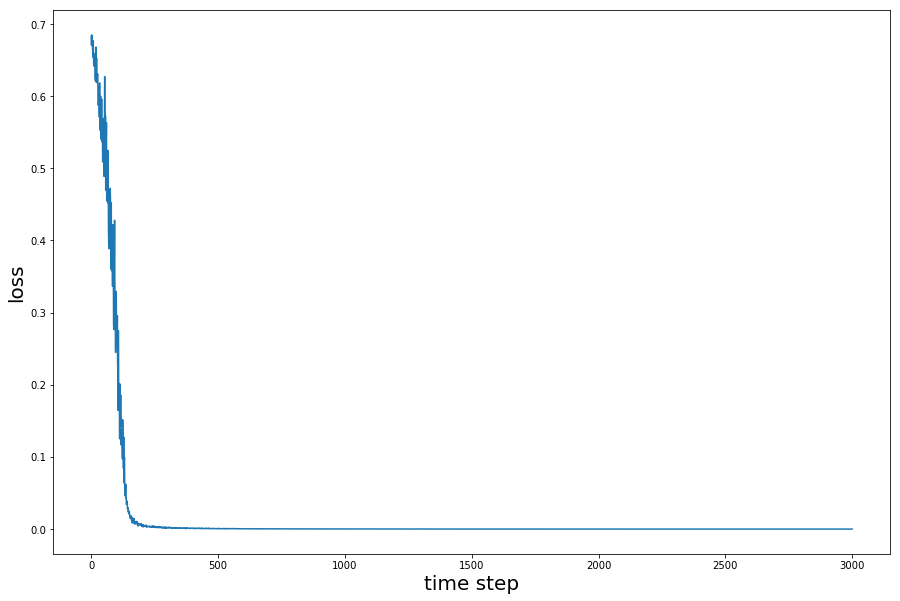

In [12]:
plt.figure(figsize=(15,10))
plt.xlabel("time step", fontsize=20)
plt.ylabel("loss", fontsize=20)
plt.plot(loss_track)
print('loss {:.10f} after {} examples (batch_size={})'.format(loss_track[-1], len(loss_track)*batch_size, batch_size))